# Projet : Conversion Rate Challenge 🥇🥈🥉

## Import des modules

In [3]:
import time
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import svm

from xgboost import XGBClassifier

from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    classification_report,
)

import matplotlib.pyplot as plt

## Chargement et préparation des données

In [4]:
conversion_train_raw_df = pd.read_csv('./data/conversion_data_train.csv')
print('Train dataset :', conversion_train_raw_df.shape)

target_feature = "converted"
numerical_features = ["age", "total_pages_visited"]
categorical_features = ["country", "new_user", "source"]

print(f"{'Target':<20}: {target_feature}")
print(f"{'Numerical features':<20}: {numerical_features}")
print(f"{'Categorical features':<20}: {categorical_features}")


Train dataset : (284580, 6)
Target              : converted
Numerical features  : ['age', 'total_pages_visited']
Categorical features: ['country', 'new_user', 'source']


In [5]:
# Numerical features
numerical_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
    ]
)

# Categorical features
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first")),
    ]
)

# Build features prepocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [6]:
train_df = conversion_train_raw_df[conversion_train_raw_df["age"] < 90]

# Divide dataset Train set & Test set
X_df = train_df.drop(columns=target_feature)
y_df = train_df[target_feature]

print("Dividing into train and test sets...")
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=75, stratify=y_df)

print("...Done.")
print()

# Preprocess the train & test datasets
X_train = preprocessor.fit_transform(X_train_df)
X_test = preprocessor.transform(X_test_df)

y_train = y_train_df.tolist()
y_test = y_test_df.tolist()

Dividing into train and test sets...
...Done.



## Fonction d'évaluation

Cette fonction calcule les métriques permettant d'évaluer notre modèle (f1,precision et recall) puis affiche (à la demande) les rapports de confusion et matrices de confusions.

In [7]:
def evaluate_model(classifier, X_train, y_train, X_test, y_test, classifier_name=None, print_details=False):
    y_train_pred = classifier.predict(X_train)
    y_test_pred = classifier.predict(X_test)

    metrics = {
        "classifier_name": classifier_name or type(classifier).__name__,
        "f1_train": f1_score(y_train, y_train_pred),
        "precision_train": precision_score(y_train,  y_train_pred),
        "recall_train": recall_score(y_train,  y_train_pred),
        "f1_test": f1_score(y_test, y_test_pred),
        "precision_test": precision_score(y_test,  y_test_pred),
        "recall_score": recall_score(y_test,  y_test_pred),
        
    }

    # Affichage des métriques
    print(f"\n📊 Évaluation pour {metrics['classifier_name']}")
    for key, value in metrics.items():
        if key != "classifier_name":
            print(f"{key}: {value:.3f}")
            
    if print_details:
        print("Confusion matrix on train set : ")
        print(confusion_matrix(y_train, y_train_pred))
        print()
        print("Confusion matrix on test set : ")
        print(confusion_matrix(y_test, y_test_pred))
        print()
        print("classification report:")
        print(classification_report(y_true=y_train, y_pred=y_train_pred))
        
        _, ax = plt.subplots(2, 2, figsize=(15,10))  # Get subplot from matplotlib

        # Visualize confusion matrices
        disp = ConfusionMatrixDisplay.from_estimator(
            classifier, X_train, y_train, ax=ax[0, 0]
        )
        disp.ax_.set_title('Confusion Matrix on Train set')

        disp = ConfusionMatrixDisplay.from_estimator(
            classifier, X_test, y_test, ax=ax[0, 1]
        ) 
        disp.ax_.set_title('Confusion Matrix on Test set')

        # Visualize ROC curves
        disp = RocCurveDisplay.from_estimator(
            classifier, X_train, y_train, ax=ax[1,0]
        ) 
        disp.ax_.set_title('ROC Curve on Train set')

        disp = RocCurveDisplay.from_estimator(
            classifier, X_test, y_test, ax=ax[1,1]
        ) 
        disp.ax_.set_title('ROC Curve on Test set')

        plt.show()
    
    return metrics

## Evaluation de plusieurs modèles pour choisir le baseline

In [37]:
from enum import Enum

class ModelType(str, Enum):
    LR = "lr"
    SVM = "svm"
    SVM_POLY = "svm_poly"
    DecisionTreeClassifier = "DecisionTreeClassifier"
    RandomForestClassifier = "RandomForestClassifier"
    XGBoost = "xgboost"

def make_model(model_type):
    if model_type == ModelType.LR:
        return LogisticRegression()
    
    if model_type == ModelType.SVM:
        # Peu adapté à la taille de notre dataset, sera lent!
        
        # 📊 Évaluation pour OneVsRestClassifier (rbf)
        # f1_train: 0.751
        # f1_test: 0.751
        # training_ms: 2.285145e+06ms = 38min
        classifier = svm.SVC(kernel='rbf', C=1.0, probability=True, random_state=75)
        return OneVsRestClassifier(classifier, n_jobs=-1)

    if model_type == ModelType.SVM_POLY:
        classifier = svm.SVC(kernel='poly', C=1.0, probability=True, random_state=75)
        return OneVsRestClassifier(classifier, n_jobs=-1)
    
    if model_type == ModelType.DecisionTreeClassifier:
        model_params = {
            'max_depth':[12, 14, 16],
            'min_samples_split':[14,18,22],
            'min_samples_leaf':[4,6,8]
        }
        return GridSearchCV(DecisionTreeClassifier(), param_grid = model_params, scoring='f1', cv=5, verbose=1, n_jobs=-1)
    
    if model_type == ModelType.RandomForestClassifier:
        model = RandomForestClassifier()
        model_params={
            'max_depth':[10],
            'min_samples_split':[5, 7, 10],
            'n_estimators':[50, 100, 150]
        }

        return GridSearchCV(estimator=model, param_grid=model_params, scoring='f1', cv=5, verbose=1, n_jobs=-1)

    if model_type == ModelType.XGBoost:
        model_params = {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5, 10],
            'subsample': [0.75],
            'colsample_bytree': [0.75],
            'gamma': [0, 0.1, 0.3, 0.5, 1.0],
            'min_child_weight': [1, 3, 5],
        }
        return GridSearchCV(estimator=XGBClassifier(), param_grid=model_params, scoring='f1', cv=5, verbose=1, n_jobs=5)


In [38]:
def assess_model(classifier_type, metrics_store):
    classifier  = make_model(classifier_type)
    print("="*80)
    print(f"Training model {classifier_type}...")    
    start_t = time.time()
    classifier.fit(X_train, y_train)
    duration_ms = (time.time() - start_t) * 1000
    print(f"...Done in {duration_ms/1000:.2f}s")

    metrics = evaluate_model(classifier, X_train, y_train, X_test, y_test, classifier_name=classifier_type.value)
    metrics["training_ms"] = duration_ms
    metrics["classifier"] = classifier

    models_metrics[classifier_type.value] = metrics


### Train & scores

In [39]:
# A place to collect all models metrics
models_metrics = {}

# ModelType.SVM: f1=0.75 / 38 min 
for classifier_type in [ModelType.LR, ModelType.SVM_POLY, ModelType.DecisionTreeClassifier, ModelType.RandomForestClassifier, ModelType.XGBoost]:
    assess_model(classifier_type, models_metrics)

Training model ModelType.LR...
...Done in 2.00s

📊 Évaluation pour lr
f1_train: 0.763
precision_train: 0.857
recall_train: 0.687
f1_test: 0.762
precision_test: 0.859
recall_score: 0.685
Training model ModelType.SVM_POLY...
...Done in 1153.57s

📊 Évaluation pour svm_poly
f1_train: 0.743
precision_train: 0.889
recall_train: 0.638
f1_test: 0.744
precision_test: 0.889
recall_score: 0.640
Training model ModelType.DecisionTreeClassifier...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
...Done in 9.41s

📊 Évaluation pour DecisionTreeClassifier
f1_train: 0.774
precision_train: 0.868
recall_train: 0.698
f1_test: 0.748
precision_test: 0.840
recall_score: 0.674
Training model ModelType.RandomForestClassifier...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
...Done in 64.98s

📊 Évaluation pour RandomForestClassifier
f1_train: 0.782
precision_train: 0.877
recall_train: 0.706
f1_test: 0.759
precision_test: 0.852
recall_score: 0.685
Training model ModelType.XGBoost...
Fi

In [40]:
lr_classifier  = make_model(ModelType.LR)

lr_cross_val_f1 = cross_val_score(lr_classifier, X_train, y_train, cv=5, scoring='f1')

lr_cross_val_f1

array([0.76334107, 0.74942879, 0.74585219, 0.77148218, 0.78264095])

In [41]:
xgb_classifier  = make_model(ModelType.XGBoost)

xgb_cross_val_f1 = cross_val_score(xgb_classifier, X_train, y_train, cv=5, scoring='f1')

xgb_cross_val_f1

Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


array([0.76289453, 0.74571216, 0.74550898, 0.77474151, 0.78408254])

### Résultats

In [42]:
# Display results
df_results = pd.DataFrame(models_metrics.values())
df_results["training_s"] = round(df_results["training_ms"] / 1000, 2)
df_results.drop(columns=["training_ms", "classifier"], inplace=True)
display(df_results.sort_values("f1_test", ascending=False))

,classifier_name,f1_train,precision_train,recall_train,f1_test,precision_test,recall_score,training_s
0,lr,0.762798,0.857386,0.687006,0.762424,0.859290,0.685185,2.00
4,xgboost,0.767503,0.852320,0.698039,0.761360,0.850706,0.688998,236.40
3,RandomForestClassifier,0.782012,0.876671,0.705802,0.759433,0.851726,0.685185,64.98
2,DecisionTreeClassifier,0.773887,0.867806,0.698311,0.747658,0.839783,0.673747,9.41
1,svm_poly,0.742961,0.889311,0.637973,0.744142,0.888805,0.639978,1153.57


Le modèle LogisticRegression semble offrir un trés bon compromis performance/coût. Même en extrayant les meilleurs paramètres pour XGBoost, le temps d'entrainement reste supérieur pour des performances pas meilleures.

Il semble pertinent de tenter avec LogisticRegression.

## Présentation du modèle v1

### Modèle

In [8]:
# Train model
print("Train model...")
challenge_classifier = LogisticRegression()
challenge_classifier.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.



📊 Évaluation pour challenge_classifier
f1_train: 0.763
precision_train: 0.857
recall_train: 0.687
f1_test: 0.762
precision_test: 0.859
recall_score: 0.685
Confusion matrix on train set : 
[[219481    839]
 [  2298   5044]]

Confusion matrix on test set : 
[[54874   206]
 [  578  1258]]

classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    220320
           1       0.86      0.69      0.76      7342

    accuracy                           0.99    227662
   macro avg       0.92      0.84      0.88    227662
weighted avg       0.99      0.99      0.99    227662



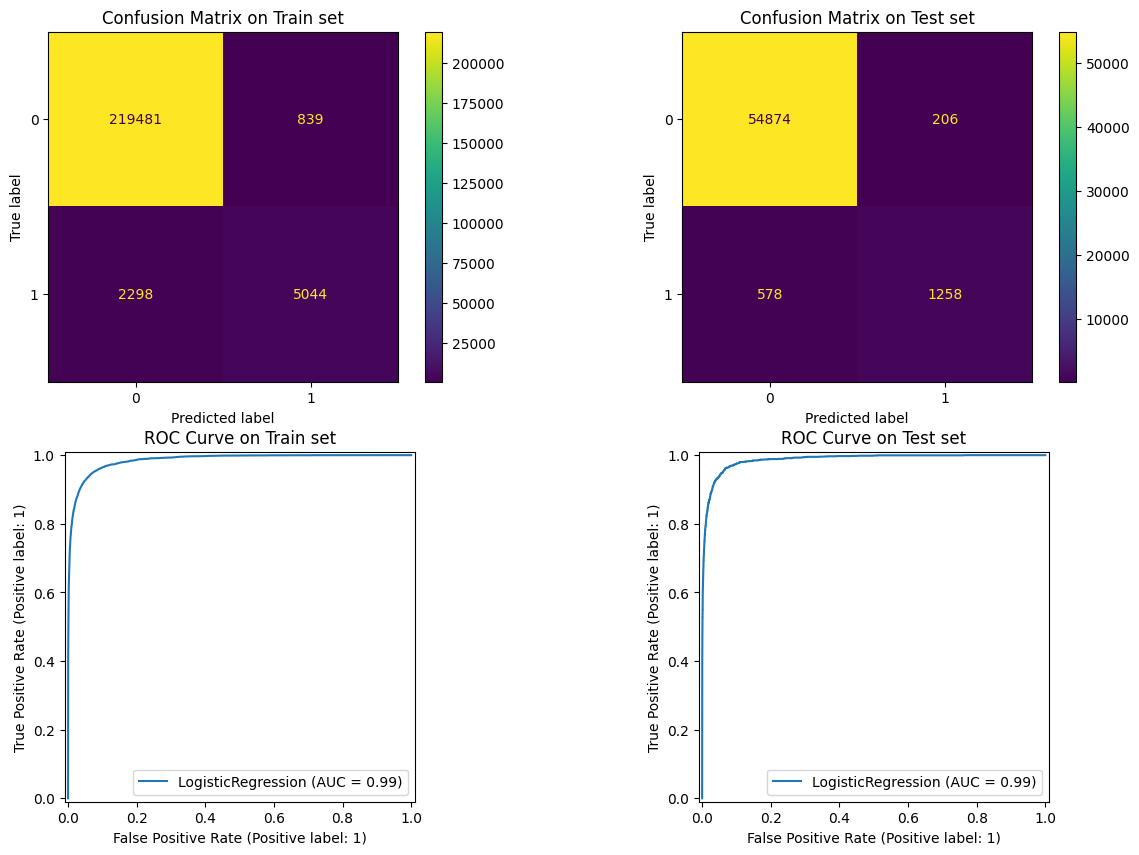

In [10]:
metrics = evaluate_model(challenge_classifier, X_train, y_train, X_test, y_test, classifier_name="challenge_classifier", print_details=True)

In [12]:
from sklearn import set_config
set_config(display="diagram")

steps = [
    ("preprocessing", preprocessor),
    ("classifier", challenge_classifier),
]

pipe = Pipeline(steps)

pipe


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age',
                                                   'total_pages_visited']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['country', 'new_user',
                                                   'source'])])),
                ('classifier', LogisticRegression())])

### The challenge

In order to compete, the model retained will be trained on the whole dataset (`conversion_data_train.csv`) and then used to predict the converted flag of the test dataset (`conversion_data_test.csv`).

In [45]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train, X_test, axis=0)
Y = np.append(y_train, y_test)

challenge_classifier.fit(X, Y)

LogisticRegression()

In [46]:
# Read data without labels
conversion_challenge_test_raw_df = pd.read_csv('./data/conversion_data_test.csv')
print('Test (Challenge / without labels) dataset :', conversion_challenge_test_raw_df.shape)

# Apply same outliers treshold as train
challenge_test_df = conversion_challenge_test_raw_df[conversion_challenge_test_raw_df["age"] < 90]

# Preprocess the test dataset
X_challenge_test = preprocessor.transform(challenge_test_df)

# Predict
y_challenge_test_preds = challenge_classifier.predict(X_challenge_test)

data = {
    'converted': y_challenge_test_preds
}

y_challenge_test_predictions = pd.DataFrame(columns=['converted'], data=data)

# Save the predictions in order to submit for the challenge
predictions_output_csv_path = f"data/predictions/conversion_data_test_predictions_CGUILLOT-v1-{time.strftime('%Y%m%d-%H%M%S')}.csv"
Path(predictions_output_csv_path).parent.mkdir(parents=True, exist_ok=True)
y_challenge_test_predictions.to_csv(predictions_output_csv_path, index=False)
print(f"Challenge predictions save at {predictions_output_csv_path}")

Test (Challenge / without labels) dataset : (31620, 5)
Challenge predictions save at data/predictions/conversion_data_test_predictions_CGUILLOT-v1-20250525-131258.csv


#### Résultats

##### Leaderboard officiel

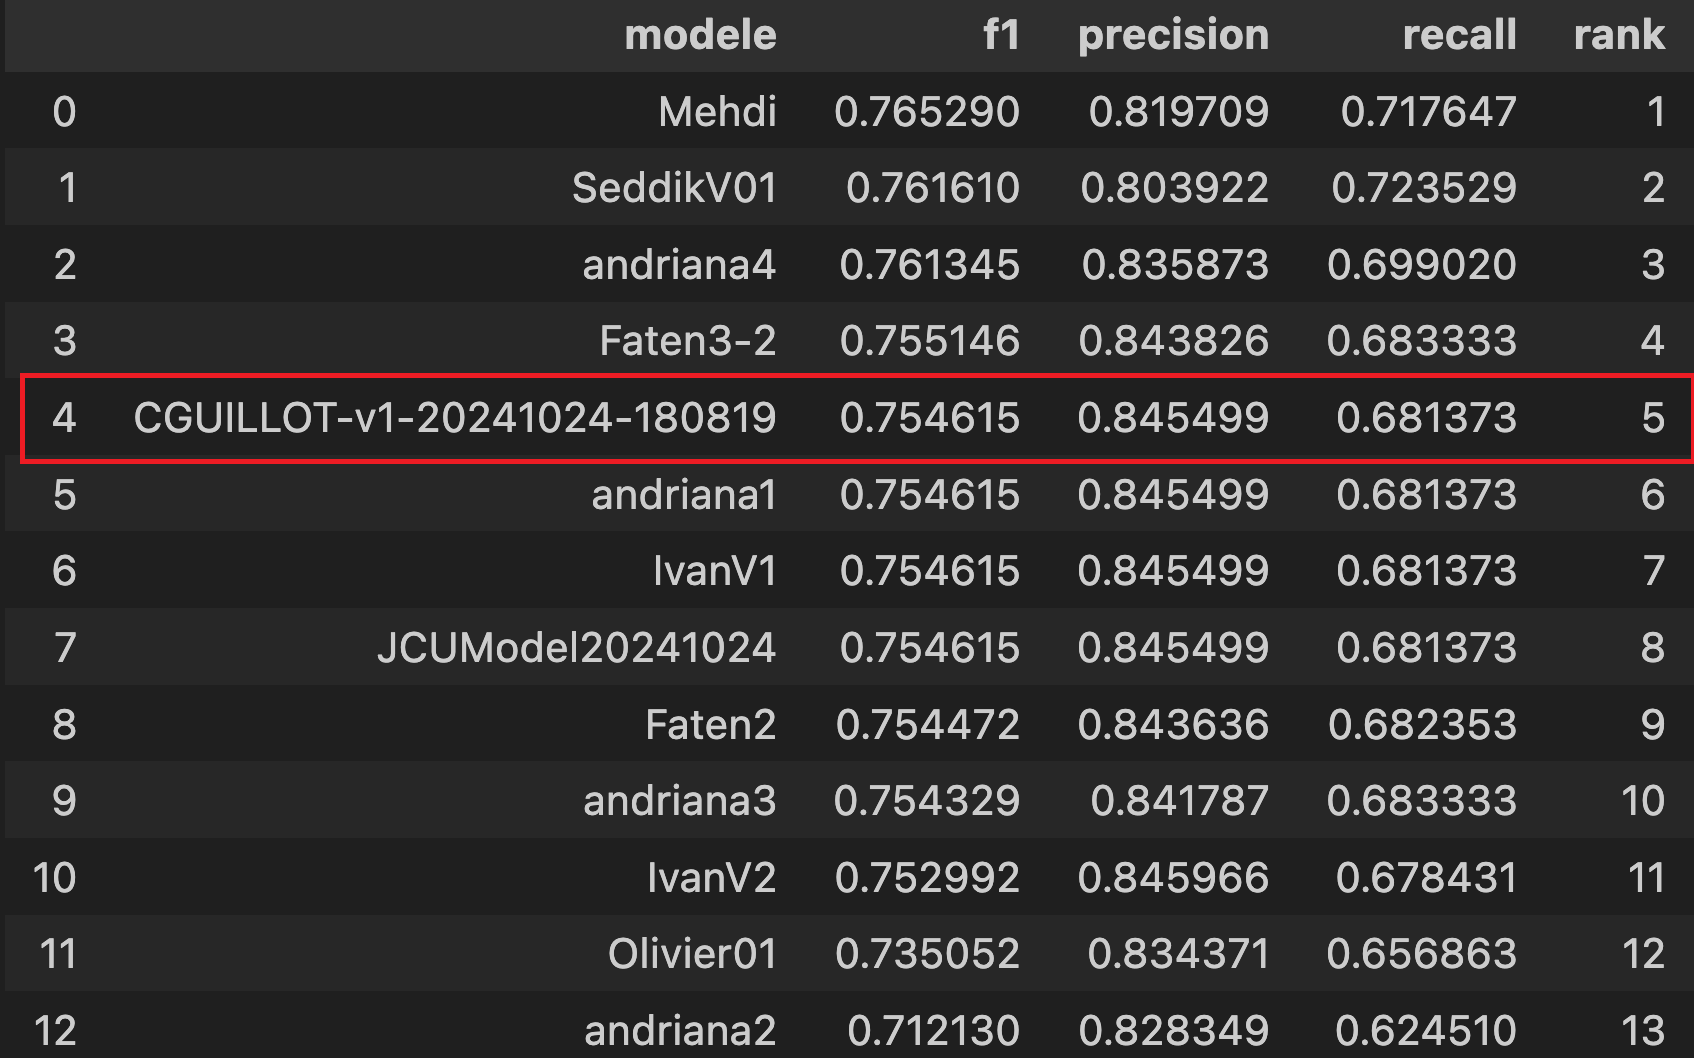

Sans surprise pas le meilleur.

##### After challenge

After competition, we were given the labelled challenge result so we can check ourself now.

In [47]:
# Rebuild challenge score
conversion_challenge_test_raw_labels_df = pd.read_csv('./data/secret/conversion_data_test_labels.csv')

challenge_f1 = f1_score(conversion_challenge_test_raw_labels_df, y_challenge_test_preds)
challenge_precision = precision_score(conversion_challenge_test_raw_labels_df, y_challenge_test_preds)
challenge_recall = recall_score(conversion_challenge_test_raw_labels_df, y_challenge_test_preds)

print(f"{'Challenge f1-score':<20}: {challenge_f1:.6f}")
print(f"{'Challenge precision':<20}: {challenge_precision:.6f}")
print(f"{'Challenge recall':<20}: {challenge_recall:.6f}")

Challenge f1-score  : 0.753938
Challenge precision : 0.845311
Challenge recall    : 0.680392
